## Import Libraries

In [1]:
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium
from IPython.display import Image
import json
sns.set()


# Get New York Neighborhood Data

In [2]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in newyork_data['features']:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [4]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## Let's visualize the neighborhoods in New York

In [5]:
latitude =40.7395704
longitude=-74.0006751

neighborhood_map = folium.Map(location=[latitude, longitude], zoom_start=10) 

# add the Neighborhoods as blue circle markers
for lat, lng, label in zip(neighborhoods['Latitude'], 
                           neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    
    folium.CircleMarker(
        [lat, lng],
        radius=1.5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0
    ).add_to(neighborhood_map)

# display map
neighborhood_map

### <center>MAP OF NYC NEIGHBORHOODS</center>

## Get NY Borough population density data. Source Wikipedia

In [6]:
columns = ['Borough', 'County', 'Population', 'GDP', 'GDP_per_capita', 
           'Area_sq_m', 'Area_sq_km', 'Density_sq_m', 'Density_sq_km']

# Read CSV file
ny_den_df = pd.read_csv('NY_density.csv',names=columns, header=None)

ny_den_df

,Borough,County,Population,GDP,GDP_per_capita,Area_sq_m,Area_sq_km,Density_sq_m,Density_sq_km
0,The Bronx,Bronx,1432132,42.695,29200,42.10,109.04,34653,13231
1,Brooklyn,Kings,2582830,91.559,34600,70.82,183.42,37137,14649
2,Manhattan,New York,1628701,600.244,360900,22.83,59.13,72033,27826
3,Queens,Queens,2278906,93.310,39600,108.53,281.09,21460,8354
4,Staten Island,Richmond,476179,14.514,30300,58.37,151.18,8112,3132


## Let's visualize the population and GDP for the New York boroughs 


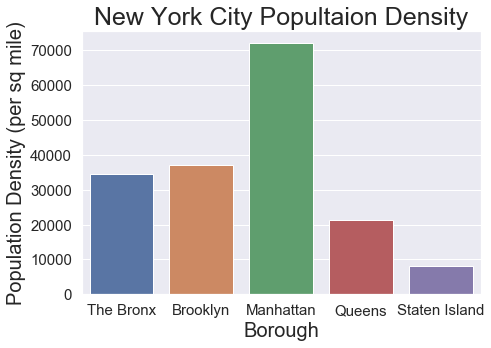

In [28]:
# Plot Population for NYC Boroughs

plt.figure(figsize= (7,5))
sns.barplot(x = ny_den_df.Borough, y = ny_den_df.Density_sq_m)
plt.xticks(rotation=0, fontsize = 15)
plt.yticks( fontsize = 15)
plt.xlabel('Borough', fontsize =20)
plt.ylabel('Population Density (per sq mile)', fontsize =20)
plt.title('New York City Popultaion Density', fontsize = 25)
plt.tight_layout()


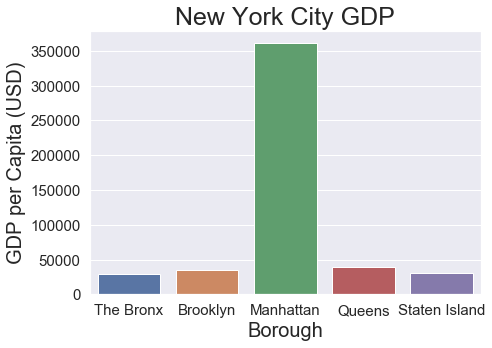

In [29]:
# Plot GDP for NYC Boroughs

plt.figure(figsize= (7,5))
sns.barplot(x = ny_den_df.Borough, y = ny_den_df.GDP_per_capita)
plt.xticks(rotation=0, fontsize = 15)
plt.yticks( fontsize = 15)
plt.xlabel('Borough', fontsize =20)
plt.ylabel('GDP per Capita (USD)', fontsize =20)
plt.title('New York City GDP', fontsize = 25)
plt.tight_layout()

### Based on population density and GDP, it is clear that Manhattan has the greatest potential to open a high-end venue. We will turn our focus on further study of the Manhattan area for our gourmet restaurant

# Manhattan Neighborhood Data

In [67]:
# Filter the NY neighborhood data to only contain Manhattan

manhattan_df = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop = True)
manhattan_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


### Let's get the population of the Manhattan Neighborhoods

In [58]:
# Read data from websource

manhattan_pop = pd.read_html('https://www.worldatlas.com/articles/manhattan-neighborhoods-by-population.html')[0]
manhattan_pop['Neighborhood'] = manhattan_pop['﻿Neighborhood']

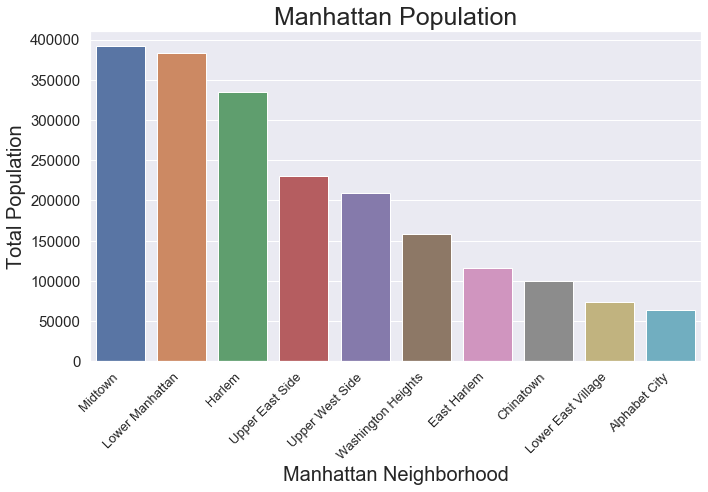

In [65]:
# Plot of Population for Manhattan Neighborhoods

plt.figure(figsize=(10,7))

sns.barplot(x = manhattan_pop['Neighborhood'].head(10), y = manhattan_pop['Population'])
plt.xticks( rotation=45, fontsize = 13, ha = 'right' )
plt.yticks(fontsize = 15)

plt.xlabel('Manhattan Neighborhood', fontsize =20)
plt.ylabel('Total Population', fontsize =20)
plt.title('Manhattan Population', fontsize = 25)
plt.tight_layout()

## Foursquare API

Foursquare classifies each venue with a price qualifier in the form of a Price Tier from 1 (least pricey) to 4 (most pricey). For food venues, in the United States, the Foursquare Price Tiers are defined as follows\:

* Tier 1 is < \$10 an entree.

* Tier 2 is $10-20 an entree.

* Tier 3 is \$20-30 an entree

* Tier 4 is > \$30 an entree

In particular, we will restrict our search to venues in the most pricey tier, as we define these as high-end venues.


### Foursuare Credentials

In [13]:
CLIENT_ID = 'UPFUJX2YZLG4F5IMCQY5IUTUKY12FCD0YFDWKE40TFS2QPQW' # your Foursquare ID
CLIENT_SECRET = 'ZWK0P1HNFOHB3W5JV4YGN45IFXI2VWADI05MSFSEX3EUCZU2' # your Foursquare Secret
VERSION = '20200504'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UPFUJX2YZLG4F5IMCQY5IUTUKY12FCD0YFDWKE40TFS2QPQW
CLIENT_SECRET:ZWK0P1HNFOHB3W5JV4YGN45IFXI2VWADI05MSFSEX3EUCZU2


## Function to send request to the Foursquare API

In [14]:
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, price_tier, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&price={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            lat, 
            lng, 
            radius, 
            LIMIT,
            price_tier)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
# API Function Call

price_tier = '4' # Return only Tier 4 venues

venues_price = getNearbyVenues(names=manhattan_df['Neighborhood'],
                               latitudes=manhattan_df['Latitude'],
                               longitudes=manhattan_df['Longitude'], 
                               price_tier = price_tier)


### Let's see what type of venues were returned

In [16]:
venues_price.groupby('Venue Category')['Venue'].nunique().sort_values(ascending=False)

Venue Category
Italian Restaurant                 20
Steakhouse                         14
American Restaurant                10
French Restaurant                   8
Japanese Restaurant                 6
Sushi Restaurant                    5
New American Restaurant             4
Cocktail Bar                        2
Korean Restaurant                   2
Spanish Restaurant                  2
Greek Restaurant                    2
Gym / Fitness Center                1
Eastern European Restaurant         1
Event Space                         1
Food Court                          1
Argentinian Restaurant              1
Gym                                 1
Theater                             1
Hotel                               1
Hotel Bar                           1
Tea Room                            1
Jewelry Store                       1
Lounge                              1
Molecular Gastronomy Restaurant     1
Nightclub                           1
Restaurant                         

### Let's filter on the venues that are restaurants and visualize the data

In [17]:
# Filter the venues to only include restaurants (including stakehouses)

manhattan_rest = venues_price[(venues_price['Venue Category'].str.contains('Restaurant', regex=True)) |
(venues_price['Venue Category'] == 'Steakhouse')]

#Drop any repeated venue to avoid double counting
manhattan_rest = manhattan_rest.drop_duplicates(subset='Venue ID', keep="first")


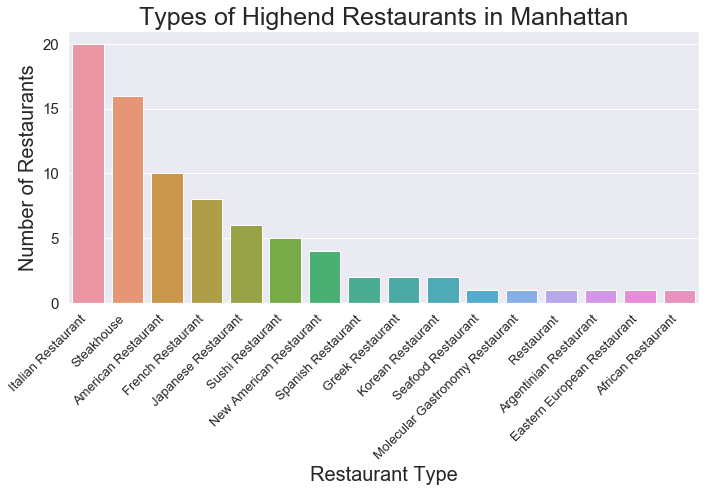

In [36]:
# Plot types of high-end restaurants in Manhattan

plt.figure(figsize=(10,7))
sns.countplot(manhattan_rest['Venue Category'], order = manhattan_rest['Venue Category'].value_counts().index)

plt.xticks( rotation=45, fontsize = 13, ha = 'right' )
plt.yticks([0,5,10,15,20], fontsize = 15)

plt.xlabel('Restaurant Type', fontsize =20)
plt.ylabel('Number of Restaurants', fontsize =20)
plt.title('Types of Highend Restaurants in Manhattan', fontsize = 25)
plt.tight_layout()


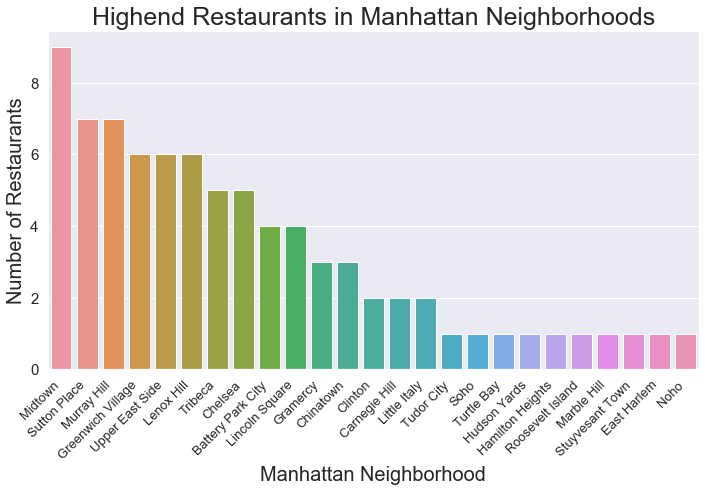

In [19]:
# Plot number of high-end restaurants in Manhattan by neighborhood

plt.figure(figsize=(10,7))
sns.countplot(manhattan_rest['Neighborhood'], order = manhattan_rest['Neighborhood'].value_counts().index)

plt.xticks(rotation=45, fontsize = 13, ha = 'right' )
plt.yticks( fontsize = 15)
plt.xlabel('Manhattan Neighborhood', fontsize =20)
plt.ylabel('Number of Restaurants', fontsize =20)
plt.title('Highend Restaurants in Manhattan Neighborhoods', fontsize = 25)
plt.tight_layout() 


## Restaurant Map

In [20]:
latitude =40.7
longitude=-73.9943

venues_map = folium.Map(location=[latitude, longitude], zoom_start=12.4, width=500,height=1000) 

# add the Italian restaurants as blue circle markers
for lat, lng, label_1, label_2 in zip(manhattan_rest['Venue Latitude'], 
                           manhattan_rest['Venue Longitude'], manhattan_rest['Venue'],
                                      manhattan_rest['Venue Category']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup= label_1 +', '+ label_2,
        fill_color='blue',
        fill_opacity=.5
    ).add_to(venues_map)

# display map
venues_map

### <center>MAP OF HIGH-END RESTAURANTS IN MANHATTAN</center>